In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
#pip install autocorrect
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
pip install autocorrect

     |████████████████████████████████| 622 kB 2.1 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.4.0-py3-none-any.whl size=621772 sha256=ddf1db5ea65129fb11639df7175a48653c10874b841b23169f8dfcb4068f1e1a
  Stored in directory: /root/.cache/pip/wheels/31/0c/85/ff881fbffcaddb50113fe65c7bcab2b7a81b996dc715ab5e36
Successfully built autocorrect
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import data
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv")

# Initial pre-processing
# 1: Remove redundant columns
df = df[['v1', 'v2']]

# 2: One hot encoding for ham/ spam label (ham = 0; spam = 1)
label = LabelEncoder()
label.fit(['ham', 'spam'])
df['v1'] = label.transform(df[['v1']])

# 3: Renaming columns
df.rename(columns = {'v1':'label', 'v2':'text'}, inplace=True)

# 4: Adding a new column for character length
df.insert(2, 'length', df['text'].apply(len))

# 5: Adding a new column for number of words count
df.insert(3, 'num_words', 
          df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1).apply(len))

# 6: Adding a new column for number of sentences count
df.insert(4, 'num_sentences',
         df.apply(lambda row: nltk.sent_tokenize(row['text']), axis=1).apply(len))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [5]:
df.head()

,label,text,length,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [88]:
# Summary
print('Overall summary')
print(df.describe().T)
print('----------------------')
print('Summary by class label')
print(df.groupby('label').describe().T)

Overall summary
                count       mean        std  min   25%   50%    75%    max
label          5572.0   0.134063   0.340751  0.0   0.0   0.0    0.0    1.0
length         5572.0  80.058327  59.623937  2.0  36.0  61.0  121.0  910.0
num_words      5572.0  18.502692  13.638372  1.0   9.0  15.0   27.0  219.0
num_sentences  5572.0   1.993001   1.503584  1.0   1.0   2.0    2.0   38.0
----------------------
Summary by class label
label                          0           1
length        count  4825.000000  747.000000
              mean     71.021347  138.429719
              std      58.014768   29.049857
              min       2.000000   13.000000
              25%      33.000000  132.000000
              50%      52.000000  149.000000
              75%      92.000000  157.000000
              max     910.000000  223.000000
num_words     count  4825.000000  747.000000
              mean     17.076062   27.717537
              std      13.875446    6.773767
              min      

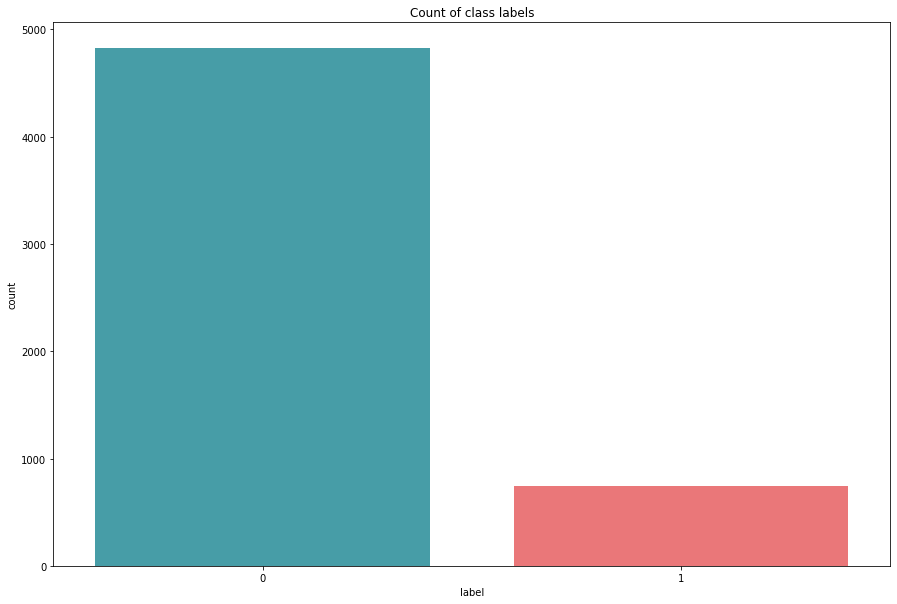

In [89]:
# EDA
# 1: Bar chart for count of observations
cols = {
    0:'#37a9b7',
    1:'#fd6467'}

plt.figure(figsize=(15,10))
fig = sns.countplot(x=df['label'], orient='h', palette=cols)
fig.set_title('Count of class labels')
plt.show(fig)

Our dataset is imbalanced. We have over 4000 rows of ham messages and only around 1000 rows of spam.

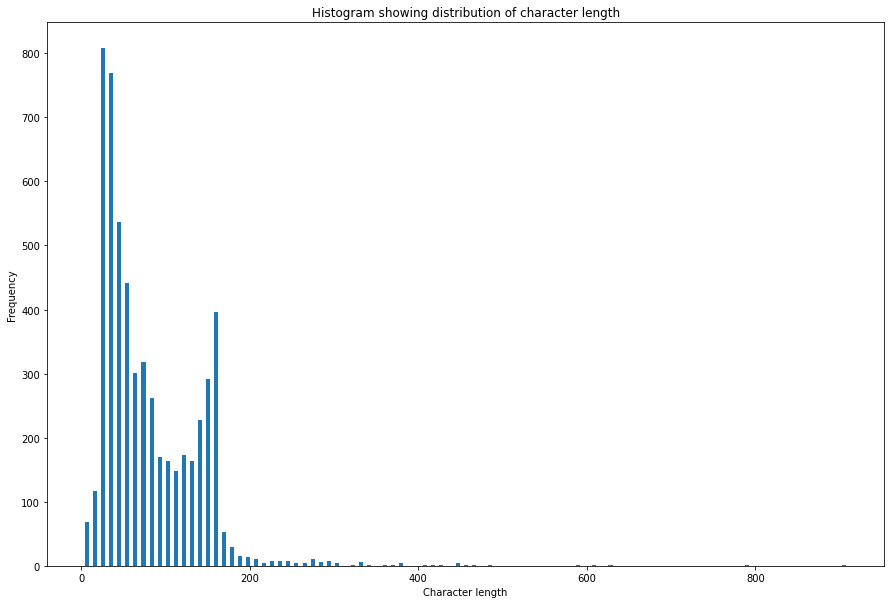

In [90]:
# 2: Histogram to look at the overall distribution
plt.figure(figsize=(15, 10))
plt.hist(x=df['length'], bins='auto', rwidth=0.5)
plt.title('Histogram showing distribution of character length')
plt.xlabel('Character length')
plt.ylabel('Frequency')
plt.show()

There are 2 obvious peaks. Next, we will examine the 3 added features by groups.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

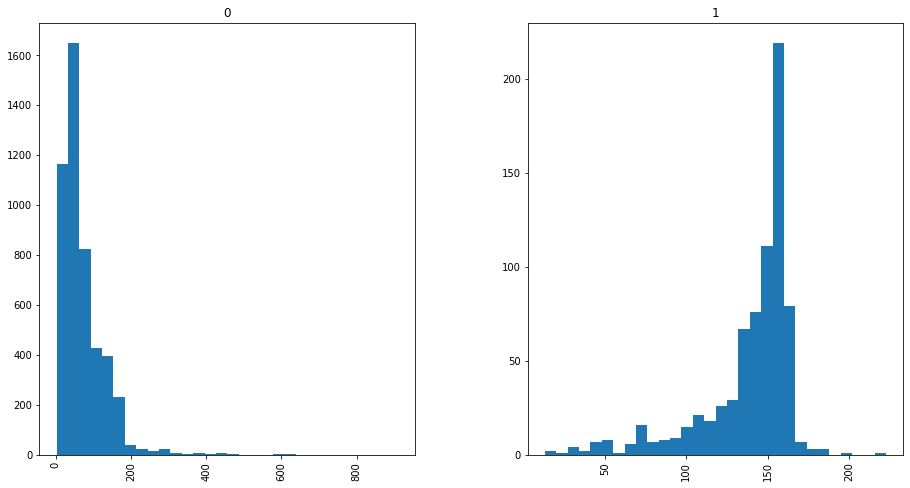

In [91]:
df.hist(column='length', by='label', bins=30, figsize=(15,8))

Now, we can see obvious peaks.
- Around 50 character lengths for hams
- Around 150 character lengths for spams

<Figure size 2160x2520 with 0 Axes>

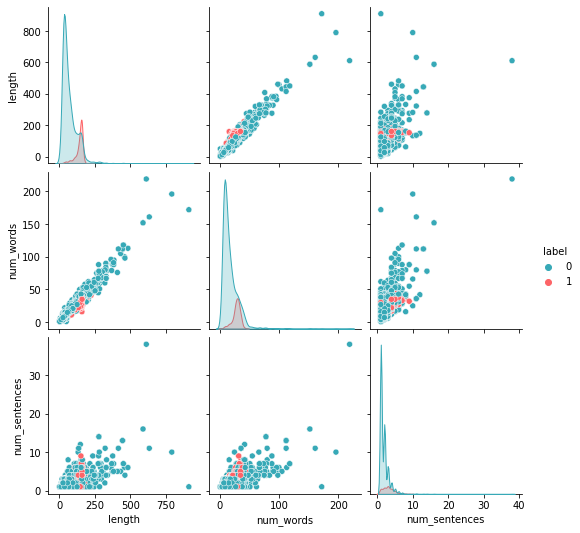

In [92]:
# Original plots
plt.figure(figsize=(30,35))
fig = sns.pairplot(data=df, hue='label', palette=cols)
plt.show(fig)

<Figure size 2160x2520 with 0 Axes>

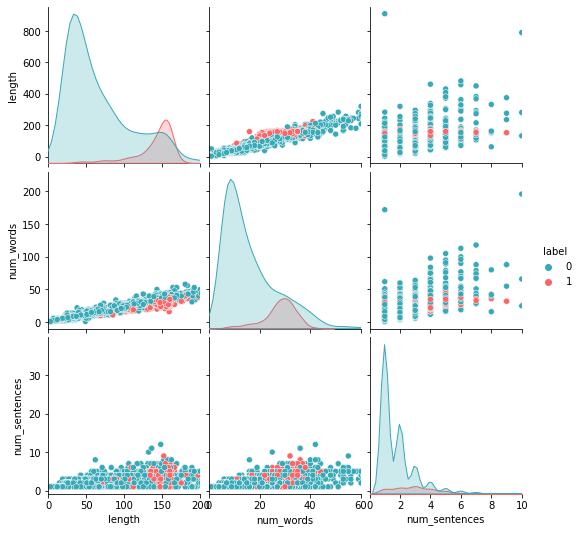

In [93]:
# Zooming in
plt.figure(figsize=(30,35))
fig = sns.pairplot(data=df, hue='label', palette=cols)

# 1st row 1st col
fig.axes[0,0].set_xlim((0,200))

# 2nd row 2nd col
fig.axes[1,1].set_xlim((0,60))

# 3rd row 3rd col
fig.axes[2,2].set_xlim((0,10))

plt.show(fig)

Both of the classes has its own distinct characteristics:
1. Characters length
   <br> a. Ham messages < 50 characters long
   <br> b. Spam messages around 150 characters long.
2. Words count
   <br> a. Ham messages < 20 words
   <br> b. Spam messages around 30 words
3. Sentences count
   <br> a. Ham messages shows multimodial distribution with distinct peaks at [1, 2, 3] sentences count
   <br> b. Spam messages has platykurtic distribution and no distinct peak

In [87]:
# Additional pre-processing functions
# currently spellcheck() is not in use - operation time takes too long (not sure why)

def spellcheck(text):
    """
    input: string
    Corrects mispelt words.
    return: string
    """
    #spell = Speller()
    return spell(text)

def remove_stopword(text):
    """
    input: string
    Remove stopwords.
    return: string without stopwords    
    """
    filtered = []
    #stopword = set(stopwords.words('english'))
    # for every word in text, append it to filtered list if the word is not in stopword set
    for word in text.split(' '):
        if word not in stopword:
            filtered.append(word)
    return ' '.join(filtered)

def get_clean_text(text):
    """
    input: string
    Convert to lowercase, remove all punctuations, remove stopwords, correct spellings.
    return: string
    """
    # do spellcheck
    #text = spellcheck(text) #operation takes too long.
    # remove stopword
    text = remove_stopword(text)
    # strip all characters other than alphanumeric, make all lowercase, trim spaces before and after
    #t = text.translate(str.maketrans("","", string.punctuation)).strip().lower() #operation takes too long.
    t = re.sub('[^a-zA-Z]', " ", text) # remove all except alphabets
    # remove double/ multiple whitespaces
    t = re.sub("\s\s+", " ", t)
    return t


def lemmatize_word(text):
    """
    input: string
    lemmatizes words. (eg teaches -> teach)
    output: string
    """
    t = []
    #wnl = WordNetLemmatizer()
    for word in text.split(' '):
        t.append(wnl.lemmatize(word))
    return " ".join(t)

def get_stem(text):
    """
    input: string
    return word stem using SnowballStemmer, ignore stopwords. (eg sailed -> sail)
    return: string
    """
    t = []
    #stemmer = SnowballStemmer('english', ignore_stopwords = True)
    for word in text.split(' '):
        t.append(stemmer.stem(word))
    return " ".join(t)

In [ ]:
# Additional pre-processing

# Initializing instances
#spell = Speller()
stemmer = SnowballStemmer('english', ignore_stopwords = True)
wnl = WordNetLemmatizer()
stopword = set(stopwords.words('english'))

# 1: Adding a new column for cleaned text
df['cleaned_text'] = df['text'].apply(get_clean_text)

# 2: Adding a new column for lemmatized text
df['lemmatize_text'] = df['cleaned_text'].apply(lemmatize_word)

# 3: Adding a new column for stemmed text
df['stem_text'] = df['lemmatize_text'].apply(get_stem)

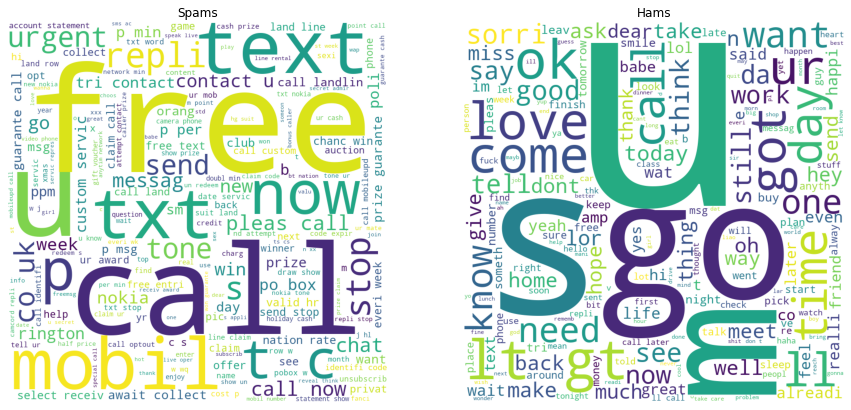

In [86]:
# Visualization

# 1: Filter only the processed text for Spam and Ham
spams = df[df['label']==1].stem_text
hams = df[df['label']==0].stem_text

# 2: Compile all in separate corpora
spam_list = []
for row in spams:
    spam_list.append(row)
    
spam_c = ' '.join([str(s) for s in spam_list])

ham_list = []
for row in hams:
    ham_list.append(row)
    
ham_c = ' '.join([str(h) for h in ham_list])

# 3: Generate wordclouds
spam_wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(spam_c)

ham_wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(ham_c)

# 4: Visualizing wordclouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
#fig.suptitle('Wordclouds')
ax1.imshow(spam_wc)
ax2.imshow(ham_wc)
ax1.title.set_text('Spams')
ax2.title.set_text('Hams')
ax1.axis('off')
ax2.axis('off')
plt.show()

In [35]:
# Vectorization & Train/ Test split

# 1: Create a corpus of all of our processed texts
corpus = []
for row in df['stem_text']:
    corpus.append(row)

# 2: Vectorization using TF-IDF & assigning it as our X variable
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# X.shape # examining the shape (5572, 6305)

# 3: Assign y variables
y = df['label']

# 4: Split test/ train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
# Model training

# 1: Initializing & fitting into naive bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 2: Predicting
y_hat = nb.predict(X_test)
y_hat_prob = nb.predict(X_test) # to get probability estimate
print(y_hat)
print(y_hat_prob)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [49]:
# Model evaluation

# 1: Classification Report
target_name = ['ham', 'spam']
print(metrics.classification_report(y_test, y_hat, target_names=target_name))

# 2: Log loss
print(f'Log loss: {metrics.log_loss(y_test, y_hat_prob):.3f}')

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       976
        spam       0.99      0.81      0.89       139

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115

Log loss: 0.836
